<a href="https://colab.research.google.com/github/appleaze/Computer-Vision/blob/main/Face_Verification_Siamense_Training.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Import and Install

In [ ]:
import cv2
import os
import uuid
from google.colab.patches import cv2_imshow
from IPython.display import display, Javascript
import base64
from PIL import Image
import io
import random

import numpy as np
import matplotlib.pyplot as plt
from google.colab import output
from sklearn.metrics import roc_curve, auc, accuracy_score, precision_score, recall_score, f1_score, classification_report, confusion_matrix, ConfusionMatrixDisplay

In [ ]:
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Layer, Conv2D, Dense, MaxPooling2D, Input, Flatten
from tensorflow.keras.metrics import Precision, Recall

In [ ]:
gpus = tf.config.experimental.list_physical_devices('GPU')
for gpu in gpus:
    tf.config.experimental.set_memory_growth(gpu, True)

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# Load Preprocess Dataset

In [ ]:
FACES_PATH = os.path.join('/content/data', 'faces')
os.makedirs(FACES_PATH, exist_ok=True)

In [ ]:
!unzip -q /content/drive/MyDrive/Data/ComputerVision/faces.zip -d /content/data/faces

In [ ]:
ANC_PATH = './data/faces/content/data/anchor/face'
POS_PATH = './data/faces/content/data/positive/face'
NEG_PATH = './data/faces/content/data/negative/face'

In [ ]:
anchor = tf.data.Dataset.list_files(ANC_PATH + '/*.jpg').take(3000)
positive = tf.data.Dataset.list_files(POS_PATH + '/*.jpg').take(3000)
negative = tf.data.Dataset.list_files(NEG_PATH + '/*.jpg').take(3000)

In [ ]:
dir_test = anchor.as_numpy_iterator()

In [ ]:
print(dir_test.next())

b'./data/faces/content/data/anchor/face/b781ec68-c8c6-11ef-8941-0242ac1c000c.jpg'


In [ ]:
def preprocess(file_path):
  byte_img = tf.io.read_file(file_path)
  img = tf.io.decode_jpeg(byte_img)
  img = tf.image.resize(img, (100, 100))
  img = img / 255.0
  return img

In [ ]:
positives = tf.data.Dataset.zip((anchor, positive, tf.data.Dataset.from_tensor_slices(tf.ones(len(anchor)))))
negatives = tf.data.Dataset.zip((anchor, negative, tf.data.Dataset.from_tensor_slices(tf.zeros(len(anchor)))))
data = positives.concatenate(negatives)

In [ ]:
samples = data.as_numpy_iterator()
exampple = samples.next()
exampple

(b'./data/faces/content/data/anchor/face/b9358524-c8c6-11ef-8941-0242ac1c000c.jpg',
 b'./data/faces/content/data/positive/face/c889cd32-c8c6-11ef-8941-0242ac1c000c.jpg',
 1.0)

In [ ]:
def preprocess_twin(input_img, validation_img, label):
  return(preprocess(input_img), preprocess(validation_img), label)

In [ ]:
res = preprocess_twin(*exampple)

1.0

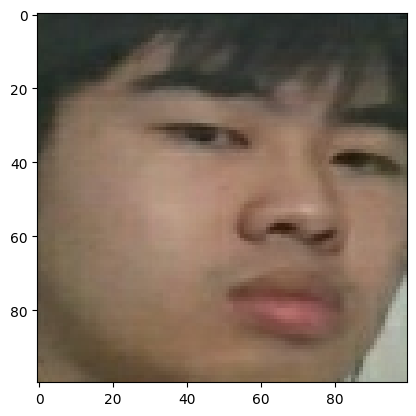

In [ ]:
plt.imshow(res[1])
res[2]

In [ ]:
data = data.map(preprocess_twin)
data = data.cache()
data = data.shuffle(buffer_size=1024)

In [ ]:
data_len = len(data)
train_size = round(data_len * 0.7)
val_size = round(data_len * 0.15)
test_size = data_len - train_size - val_size

In [ ]:
train = data.take(train_size)
remainder = data.skip(train_size)
val = remainder.take(val_size)
test = remainder.skip(val_size)

In [ ]:
batch_size = 32
prefetch_buffer = 8

train_data = train.batch(batch_size).prefetch(prefetch_buffer)
val_data = train.batch(batch_size).prefetch(prefetch_buffer)
test_data = test.batch(batch_size).prefetch(prefetch_buffer)

# Test Sample

In [ ]:
samples = data.as_numpy_iterator()
len(samples.next())
samp = samples.next()

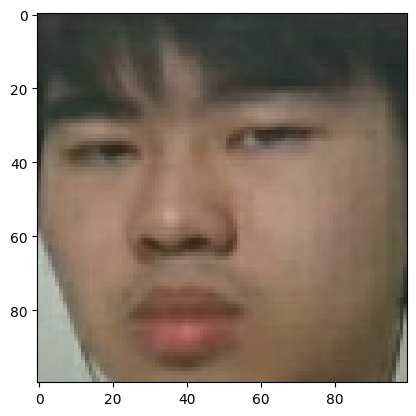

In [ ]:
plt.imshow(samples.next()[0])

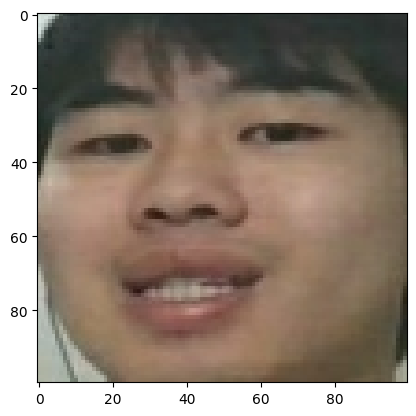

In [ ]:
plt.imshow(samples.next()[1])

In [ ]:
samp[2]

1.0

# Model Engineering

In [ ]:
def make_embedding():
  inp = Input(shape=(100, 100, 3), name='input_image')

  c1 = Conv2D(64, (10, 10), activation='relu')(inp)
  m1 = MaxPooling2D(64, (2, 2), padding='same')(c1)

  c2 = Conv2D(128, (7, 7), activation='relu')(m1)
  m2 = MaxPooling2D(64, (2, 2), padding='same')(c2)

  c3 = Conv2D(128, (4,4), activation='relu')(m2)
  m3 = MaxPooling2D(64, (2, 2), padding='same')(c3)

  c4 = Conv2D(256, (4,4), activation='relu')(m3)
  f1 = Flatten()(c4)
  d1 = Dense(4096, activation='sigmoid')(f1)

  return Model(inputs=[inp], outputs=[d1], name='embedding')

In [ ]:
class L1Dist(Layer):
    def __init__(self, **kwargs):
        super().__init__()

    def call(self, input_embedding, validation_embedding):
        return tf.math.abs(input_embedding[0] - validation_embedding[0])

In [ ]:
embedding = make_embedding()

In [ ]:
def make_siamese_model():
    input_image = Input(name='input_img', shape=(100,100,3))

    validation_image = Input(name='validation_img', shape=(100,100,3))

    siamese_layer = L1Dist()
    siamese_layer._name = 'distance'
    distances = siamese_layer(embedding(input_image), embedding(validation_image))

    classifier = Dense(1, activation='sigmoid')(distances)

    return Model(inputs=[input_image, validation_image], outputs=classifier, name='SiameseNetwork')

In [ ]:
siamese_model = make_siamese_model()

In [ ]:
siamese_model.summary()

Model: "SiameseNetwork"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_img (InputLayer)    │ (None, 100, 100, 3)    │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ validation_img            │ (None, 100, 100, 3)    │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ embedding (Functional)    │ (None, 4096)           │     38,960,448 │ input_img[0][0],       │
│                           │                        │                │ validation_img[0][0]   │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ l1_dist (L1Dist)          │ (None, 4096)           │              0 │ embedding[0][0],       │
│                           │                        │                │ embedding[1][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_1 (Dense)           │ (None, 1)              │          4,097 │ l1_dist[0][0]          │
└───────────────────────────┴────────────────────────┴────────────────┴────────────────────────┘

 Total params: 38,964,545 (148.64 MB)

 Trainable params: 38,964,545 (148.64 MB)

 Non-trainable params: 0 (0.00 B)

# Model Training

In [ ]:
binary_cross_loss = tf.losses.BinaryCrossentropy()
opt = tf.keras.optimizers.Adam(1e-4)

In [ ]:
test_batch = train_data.as_numpy_iterator()

In [ ]:
batch_1 = test_batch.next()

In [ ]:
X = batch_1[:2]

In [ ]:
y = batch_1[2]

In [ ]:
y

array([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
      dtype=float32)

In [ ]:
@tf.function
def train_step(batch):

  with tf.GradientTape() as tape:
    X = batch[:2]
    y = batch[2]

    yhat = siamese_model(X, training=True)
    loss = binary_cross_loss(y, yhat)

  print(loss)
  grad = tape.gradient(loss, siamese_model.trainable_variables)
  opt.apply_gradients(zip(grad, siamese_model.trainable_variables))

  return loss

In [ ]:
@tf.function
def test_step(batch):
    X = batch[:2]

    y = batch[2]

    yhat = siamese_model(X, training=False)
    loss = binary_cross_loss(y, yhat)

    return loss, yhat

In [ ]:
def train(data, val_data, EPOCHS, patience=3):
    train_metrics = {"loss": [], "recall": [], "precision": []}
    val_metrics = {"loss": [], "recall": [], "precision": []}

    best_val_loss = float("inf")
    wait = 0  # Counter for patience

    for epoch in range(1, EPOCHS + 1):
        print('\n Epoch {}/{}'.format(epoch, EPOCHS))
        progbar = tf.keras.utils.Progbar(len(data))

        # Training metrics
        train_r = Recall()
        train_p = Precision()
        epoch_train_losses = []

        # Validation metrics
        val_r = Recall()
        val_p = Precision()
        epoch_val_losses = []

        # Training loop
        for idx, batch in enumerate(data):
            loss = train_step(batch)
            yhat = siamese_model.predict(batch[:2])
            train_r.update_state(batch[2], yhat)
            train_p.update_state(batch[2], yhat)
            epoch_train_losses.append(loss.numpy())
            progbar.update(idx + 1)

        # Record epoch training metrics
        avg_train_loss = sum(epoch_train_losses) / len(epoch_train_losses)
        train_metrics["loss"].append(avg_train_loss)
        train_metrics["recall"].append(train_r.result().numpy())
        train_metrics["precision"].append(train_p.result().numpy())

        print(f"Train Loss: {avg_train_loss}, Recall: {train_r.result().numpy()}, Precision: {train_p.result().numpy()}")

        # Validation loop
        for val_batch in val_data:
            val_loss, val_yhat = test_step(val_batch)
            epoch_val_losses.append(val_loss.numpy())
            val_r.update_state(val_batch[2], val_yhat)
            val_p.update_state(val_batch[2], val_yhat)

        # Record epoch validation metrics
        avg_val_loss = sum(epoch_val_losses) / len(epoch_val_losses)
        val_metrics["loss"].append(avg_val_loss)
        val_metrics["recall"].append(val_r.result().numpy())
        val_metrics["precision"].append(val_p.result().numpy())

        print(f"Validation Loss: {avg_val_loss}, Recall: {val_r.result().numpy()}, Precision: {val_p.result().numpy()}")

        # Early stopping check
        if avg_val_loss < best_val_loss:
            best_val_loss = avg_val_loss
            wait = 0  # Reset patience counter
            print(f"Validation loss improved to {best_val_loss}.")
        else:
            wait += 1
            print(f"No improvement in validation loss for {wait} epoch(s).")
            if wait >= patience:
                print("Early stopping triggered.")
                break

    return train_metrics, val_metrics

In [ ]:
EPOCHS = 20
train_metrics, val_metrics = train(train_data, val_data, EPOCHS)


 Epoch 1/20
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 153ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 239ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 220ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 166ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 203ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 240ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 190ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 141ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 102ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 279ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 284ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 254ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 283ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 282ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 278ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 276ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 281ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 281ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 282ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 279ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 275ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 279ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 268ms/step
1/1 ━━━━━━━━━━━━

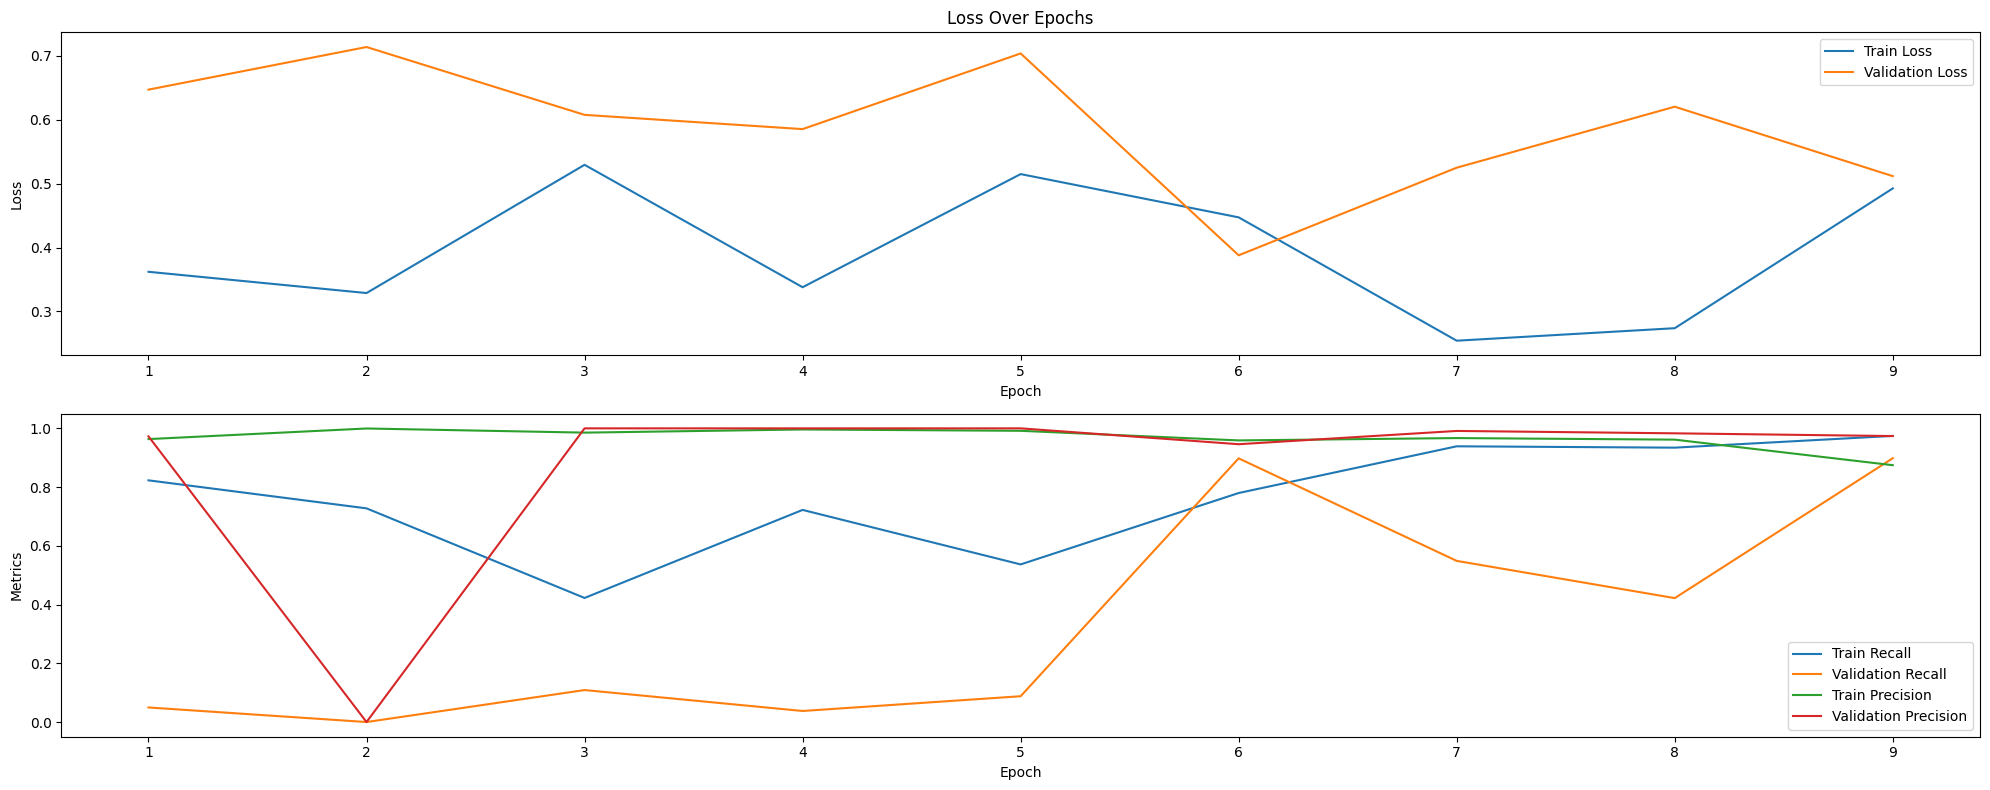

In [ ]:
import matplotlib.pyplot as plt

# Determine the number of completed epochs
completed_epochs = len(train_metrics["loss"])

plt.figure(figsize=(20, 8))

# Plot Loss
plt.subplot(2, 1, 1)
plt.plot(range(1, completed_epochs + 1), train_metrics["loss"], label="Train Loss")
plt.plot(range(1, completed_epochs + 1), val_metrics["loss"], label="Validation Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.title("Loss Over Epochs")

# Plot Metrics (Recall and Precision)
plt.subplot(2, 1, 2)
plt.plot(range(1, completed_epochs + 1), train_metrics["recall"], label="Train Recall")
plt.plot(range(1, completed_epochs + 1), val_metrics["recall"], label="Validation Recall")
plt.plot(range(1, completed_epochs + 1), train_metrics["precision"], label="Train Precision")
plt.plot(range(1, completed_epochs + 1), val_metrics["precision"], label="Validation Precision")
plt.xlabel("Epoch")
plt.ylabel("Metrics")
plt.legend()

plt.tight_layout()
plt.show()

# Model Evaluation

In [ ]:
test_input, test_val, y_true = test_data.as_numpy_iterator().next()

In [ ]:
def evaluate_siamese_batch(model, test_data):
    test_input, test_val, y_true = test_data.as_numpy_iterator().next()
    y_prob = model.predict([test_input, test_val])

    # Calculate ROC curve and metrics
    fpr, tpr, thresholds = roc_curve(y_true, y_prob)
    roc_auc = auc(fpr, tpr)

    # Find optimal thresholds
    optimal_thresholds = {
        'youden': thresholds[np.argmax(tpr - fpr)],
        'accuracy': 0,
        'f1': 0
    }

    best_metrics = {'accuracy': 0, 'f1': 0}

    # Find best thresholds
    for threshold in thresholds:
        y_pred = (y_prob >= threshold).astype(int)
        acc = accuracy_score(y_true, y_pred)
        f1 = f1_score(y_true, y_pred)

        if acc > best_metrics['accuracy']:
            best_metrics['accuracy'] = acc
            optimal_thresholds['accuracy'] = threshold
        if f1 > best_metrics['f1']:
            best_metrics['f1'] = f1
            optimal_thresholds['f1'] = threshold

    # Calculate final metrics using F1-optimal threshold
    final_predictions = (y_prob >= optimal_thresholds['f1']).astype(int)

    metrics = {
        'accuracy': accuracy_score(y_true, final_predictions),
        'precision': precision_score(y_true, final_predictions),
        'recall': recall_score(y_true, final_predictions),
        'f1': f1_score(y_true, final_predictions),
        'auc': roc_auc
    }

    # Plot ROC curve
    plt.figure(figsize=(8, 6))
    plt.plot(fpr, tpr, label=f'ROC curve (AUC = {roc_auc:.3f})')
    plt.plot([0, 1], [0, 1], linestyle='--')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Curve')
    plt.legend()
    plt.show()

    print("\nOptimal Thresholds:", {k: f"{v:.3f}" for k, v in optimal_thresholds.items()})
    print("\nMetrics with F1-optimal threshold:", {k: f"{v:.4f}" for k, v in metrics.items()})
    print("\nClass Distribution:", np.unique(y_true, return_counts=True))

    return metrics, optimal_thresholds, final_predictions

In [ ]:
def test_batch_with_threshold(model, test_data, threshold=0.574):
    test_input, test_val, y_true = test_data.as_numpy_iterator().next()

    # Get predictions
    y_prob = model.predict([test_input, test_val])
    y_pred = (y_prob >= threshold).astype(int)

    # Calculate metrics
    metrics = {
        'accuracy': accuracy_score(y_true, y_pred),
        'precision': precision_score(y_true, y_pred),
        'recall': recall_score(y_true, y_pred),
        'f1': f1_score(y_true, y_pred)
    }

    print(f"\nResults with threshold {threshold:.3f}:")
    print(f"True Labels:", y_true)
    print(f"Predictions:", y_pred.flatten())
    print(f"Probabilities:", y_prob.flatten())
    print("\nMetrics:", {k: f"{v:.4f}" for k, v in metrics.items()})
    print("Class Distribution:", np.unique(y_true, return_counts=True))

    return y_pred, y_prob, metrics

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step


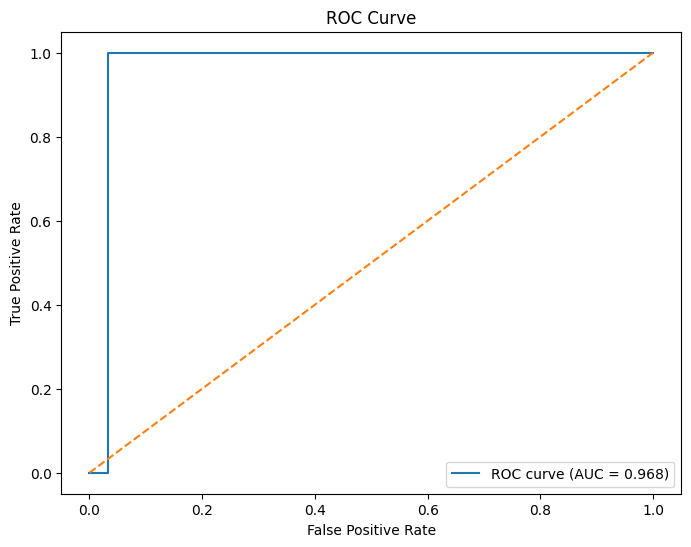


Optimal Thresholds: {'youden': '0.516', 'accuracy': 'inf', 'f1': '0.516'}

Metrics with F1-optimal threshold: {'accuracy': '0.9688', 'precision': '0.5000', 'recall': '1.0000', 'f1': '0.6667', 'auc': '0.9677'}

Class Distribution: (array([0., 1.], dtype=float32), array([31,  1]))
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step

Results with threshold 0.516:
True Labels: [0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 1. 0. 0. 0. 0. 0. 0. 0.]
Predictions: [0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 0 1 0 0 0 0 0 0 0]
Probabilities: [0.03581198 0.04099277 0.03736655 0.03582099 0.03567781 0.0372253
 0.05499597 0.51956344 0.03856353 0.03567613 0.03746402 0.12203202
 0.05294021 0.35021764 0.19397257 0.06077899 0.03740644 0.03569096
 0.03759114 0.03601782 0.0358561  0.51920736 0.5195559  0.03573632
 0.51952136 0.03712205 0.04898804 0.09266659 0.03578649 0.03765773
 0.04280081 0.0375951 ]

Metrics: {'accuracy': '0.9375', 'precision': '0.5000', 'recall': '1.0000', 'f1': '0.6

In [ ]:
# First find optimal threshold
metrics, thresholds, _ = evaluate_siamese_batch(siamese_model, test_data)
best_threshold = thresholds['youden']

# Test batch with optimal threshold
predictions, probabilities, batch_metrics = test_batch_with_threshold(siamese_model, test_data, threshold=best_threshold)

In [ ]:
def evaluate_siamese_complete(model, test_data, validation_data=None):
    """
    Complete evaluation of Siamese network including:
    1. Find optimal threshold using validation data (or test data if no validation)
    2. Evaluate full test set with optimal threshold
    """
    # Function to get predictions for a dataset
    def get_predictions(dataset):
        all_y_true = []
        all_y_prob = []

        for batch in dataset.as_numpy_iterator():
            inputs, vals, labels = batch
            probs = model.predict([inputs, vals], verbose=0)
            all_y_true.extend(labels)
            all_y_prob.extend(probs.flatten())

        return np.array(all_y_true), np.array(all_y_prob)

    # Get validation predictions (or use test data if no validation provided)
    val_data = validation_data if validation_data is not None else test_data
    val_true, val_prob = get_predictions(val_data)

    # Find optimal thresholds using validation data
    fpr, tpr, thresholds = roc_curve(val_true, val_prob)
    roc_auc = auc(fpr, tpr)

    # Calculate optimal thresholds
    optimal_thresholds = {}
    best_metrics = {'accuracy': 0, 'f1': 0}

    for threshold in thresholds:
        val_pred = (val_prob >= threshold).astype(int)
        acc = accuracy_score(val_true, val_pred)
        f1 = f1_score(val_true, val_pred)

        if acc > best_metrics['accuracy']:
            best_metrics['accuracy'] = acc
            optimal_thresholds['accuracy'] = threshold
        if f1 > best_metrics['f1']:
            best_metrics['f1'] = f1
            optimal_thresholds['f1'] = threshold

    optimal_thresholds['youden'] = thresholds[np.argmax(tpr - fpr)]

    # Plot ROC curve
    plt.figure(figsize=(8, 6))
    plt.plot(fpr, tpr, label=f'ROC curve (AUC = {roc_auc:.3f})')
    plt.plot([0, 1], [0, 1], linestyle='--')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Curve')
    plt.legend()
    plt.show()

    # Get test set predictions
    test_true, test_prob = get_predictions(test_data)

    # Calculate metrics for each threshold on test set
    results = {}
    for threshold_name, threshold in optimal_thresholds.items():
        test_pred = (test_prob >= threshold).astype(int)

        metrics = {
            'threshold': threshold,
            'accuracy': accuracy_score(test_true, test_pred),
            'precision': precision_score(test_true, test_pred),
            'recall': recall_score(test_true, test_pred),
            'f1': f1_score(test_true, test_pred),
            'auc': roc_auc
        }
        results[threshold_name] = metrics

        print(f"\nResults with {threshold_name} threshold ({threshold:.3f}):")
        print("Metrics:", {k: f"{v:.4f}" for k, v in metrics.items() if k != 'threshold'})

    print("\nClass Distribution:", np.unique(test_true, return_counts=True))

    return results, optimal_thresholds, test_prob, test_true

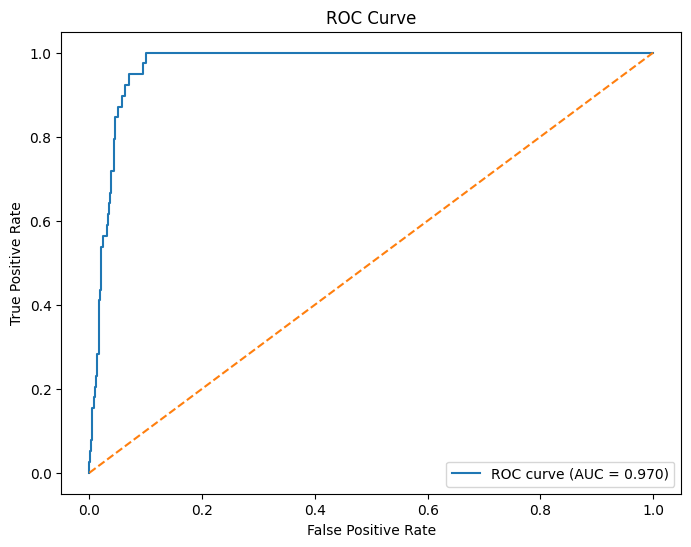


Results with accuracy threshold (0.519):
Metrics: {'accuracy': '0.9478', 'precision': '0.5676', 'recall': '0.4038', 'f1': '0.4719', 'auc': '0.9705'}

Results with f1 threshold (0.515):
Metrics: {'accuracy': '0.9478', 'precision': '0.5342', 'recall': '0.7500', 'f1': '0.6240', 'auc': '0.9705'}

Results with youden threshold (0.142):
Metrics: {'accuracy': '0.9044', 'precision': '0.3768', 'recall': '1.0000', 'f1': '0.5474', 'auc': '0.9705'}

Class Distribution: (array([0., 1.], dtype=float32), array([848,  52]))

Best threshold: 0.515
Best F1 Score: 0.6240


In [ ]:
results, thresholds, probs, true_labels = evaluate_siamese_complete(siamese_model, test_data)

# Get best F1 threshold results
best_results = results['f1']
print(f"\nBest threshold: {best_results['threshold']:.3f}")
print(f"Best F1 Score: {best_results['f1']:.4f}")

In [ ]:
print(classification_report(true_labels, (probs >= best_results['threshold']).astype(int)))

              precision    recall  f1-score   support

         0.0       0.98      0.96      0.97       848
         1.0       0.53      0.75      0.62        52

    accuracy                           0.95       900
   macro avg       0.76      0.85      0.80       900
weighted avg       0.96      0.95      0.95       900



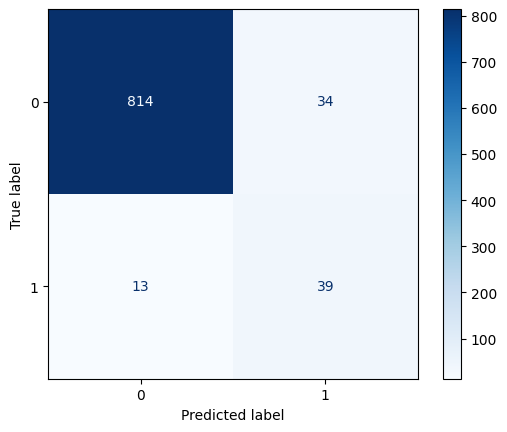

In [ ]:
cm = confusion_matrix(true_labels, (probs >= best_results['threshold']).astype(int))
disp = ConfusionMatrixDisplay(confusion_matrix=cm)

disp.plot(cmap ='Blues')
plt.show()

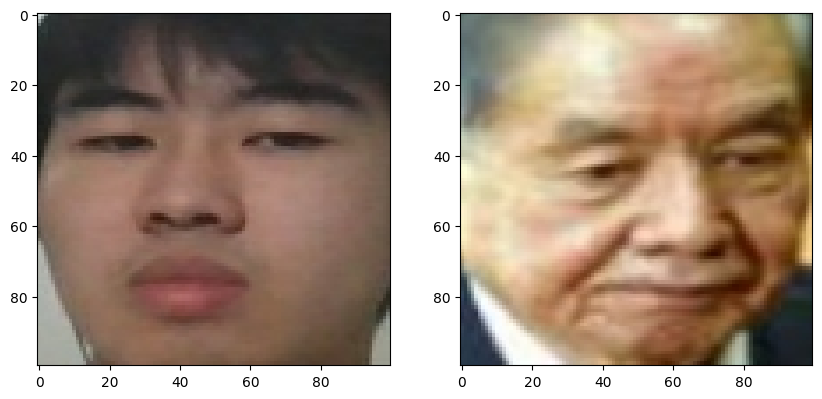

In [ ]:
plt.figure(figsize=(10,8))

plt.subplot(1,2,1)
plt.imshow(test_input[0])

plt.subplot(1,2,2)
plt.imshow(test_val[0])

plt.show()

In [ ]:
  siamese_model.save('siamesemodelv2.keras')